<a href="https://colab.research.google.com/github/GVSU-CIS635/GVSU-CIS635-Project-Team-Data_Alliance/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from statistics import mean, stdev
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_streamflow = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Final Project/streamflow.csv', header = 0, names = ['id','year','month','day','date','q(m3/s)'])
display(df_streamflow.head())
print('\nThis dataset contains', df_streamflow.shape[0], 'rows and', df_streamflow.shape[1], 'columns')

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690.0
1,11964,1967,1,2,1967-01-02,2650.0
2,11965,1967,1,3,1967-01-03,2650.0
3,11966,1967,1,4,1967-01-04,2610.0
4,11967,1967,1,5,1967-01-05,2570.0



This dataset contains 18628 rows and 6 columns


In [ ]:
#Attribute Classification
Categorical = ['id','year','month','day','date']
Numeric = ['q(m3/s)']

#Identify duplicates and drop them
duplication = df_streamflow[df_streamflow.duplicated(keep=False)]
print(f"df_streamflow dataframe has {duplication.shape[0]} duplicated samples.")

# df_streamflow.drop_duplicates()

df_streamflow dataframe has 0 duplicated samples.


In [ ]:
#Exploratory Data Analysis
df_streamflow.info()

#print descriptive statisics
display(df_streamflow.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18628 non-null  int64  
 1   year     18628 non-null  int64  
 2   month    18628 non-null  int64  
 3   day      18628 non-null  int64  
 4   date     18628 non-null  object 
 5   q(m3/s)  18040 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


,id,year,month,day,q(m3/s)
count,18628.000000,18628.00000,18628.000000,18628.000000,18040.000000
mean,21276.500000,1992.00000,6.522869,15.729815,10671.594654
std,5377.584743,14.72017,3.448812,8.800403,14275.949377
min,11963.000000,1967.00000,1.000000,1.000000,182.840000
25%,16619.750000,1979.00000,4.000000,8.000000,1419.000000
50%,21276.500000,1992.00000,7.000000,16.000000,3060.000000
75%,25933.250000,2005.00000,10.000000,23.000000,15300.000000
max,30590.000000,2017.00000,12.000000,31.000000,79059.000000


In [ ]:
#Identify missing values
df_streamflow[df_streamflow.columns].isin([np.NaN]).sum().sort_values(ascending = False)

q(m3/s)    588
id           0
year         0
month        0
day          0
date         0
dtype: int64

<ipython-input-33-7bfc5d746ffc>:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


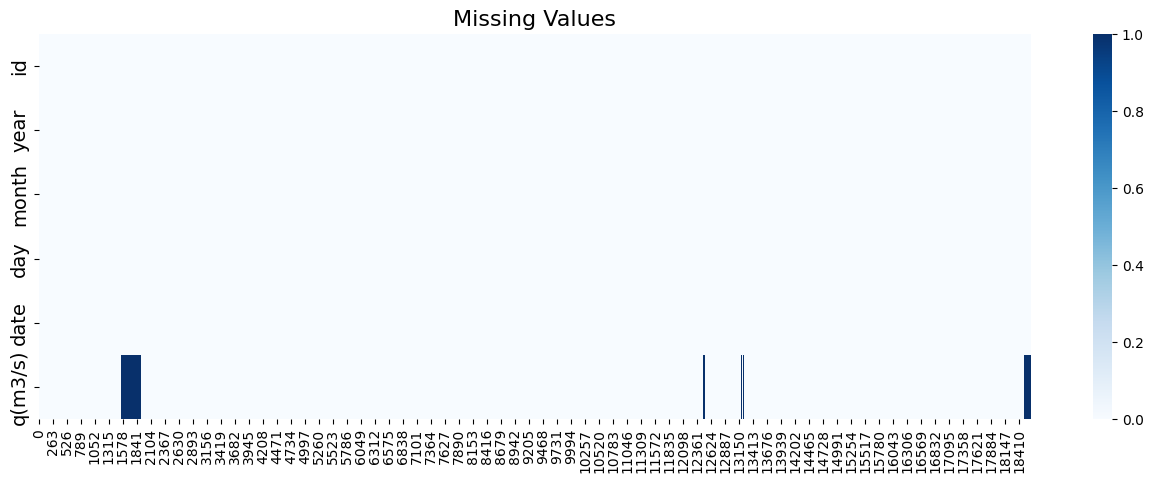

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

#view missing values in a graph
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_streamflow.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Text(0, 0.5, 'Q (m3/s)')

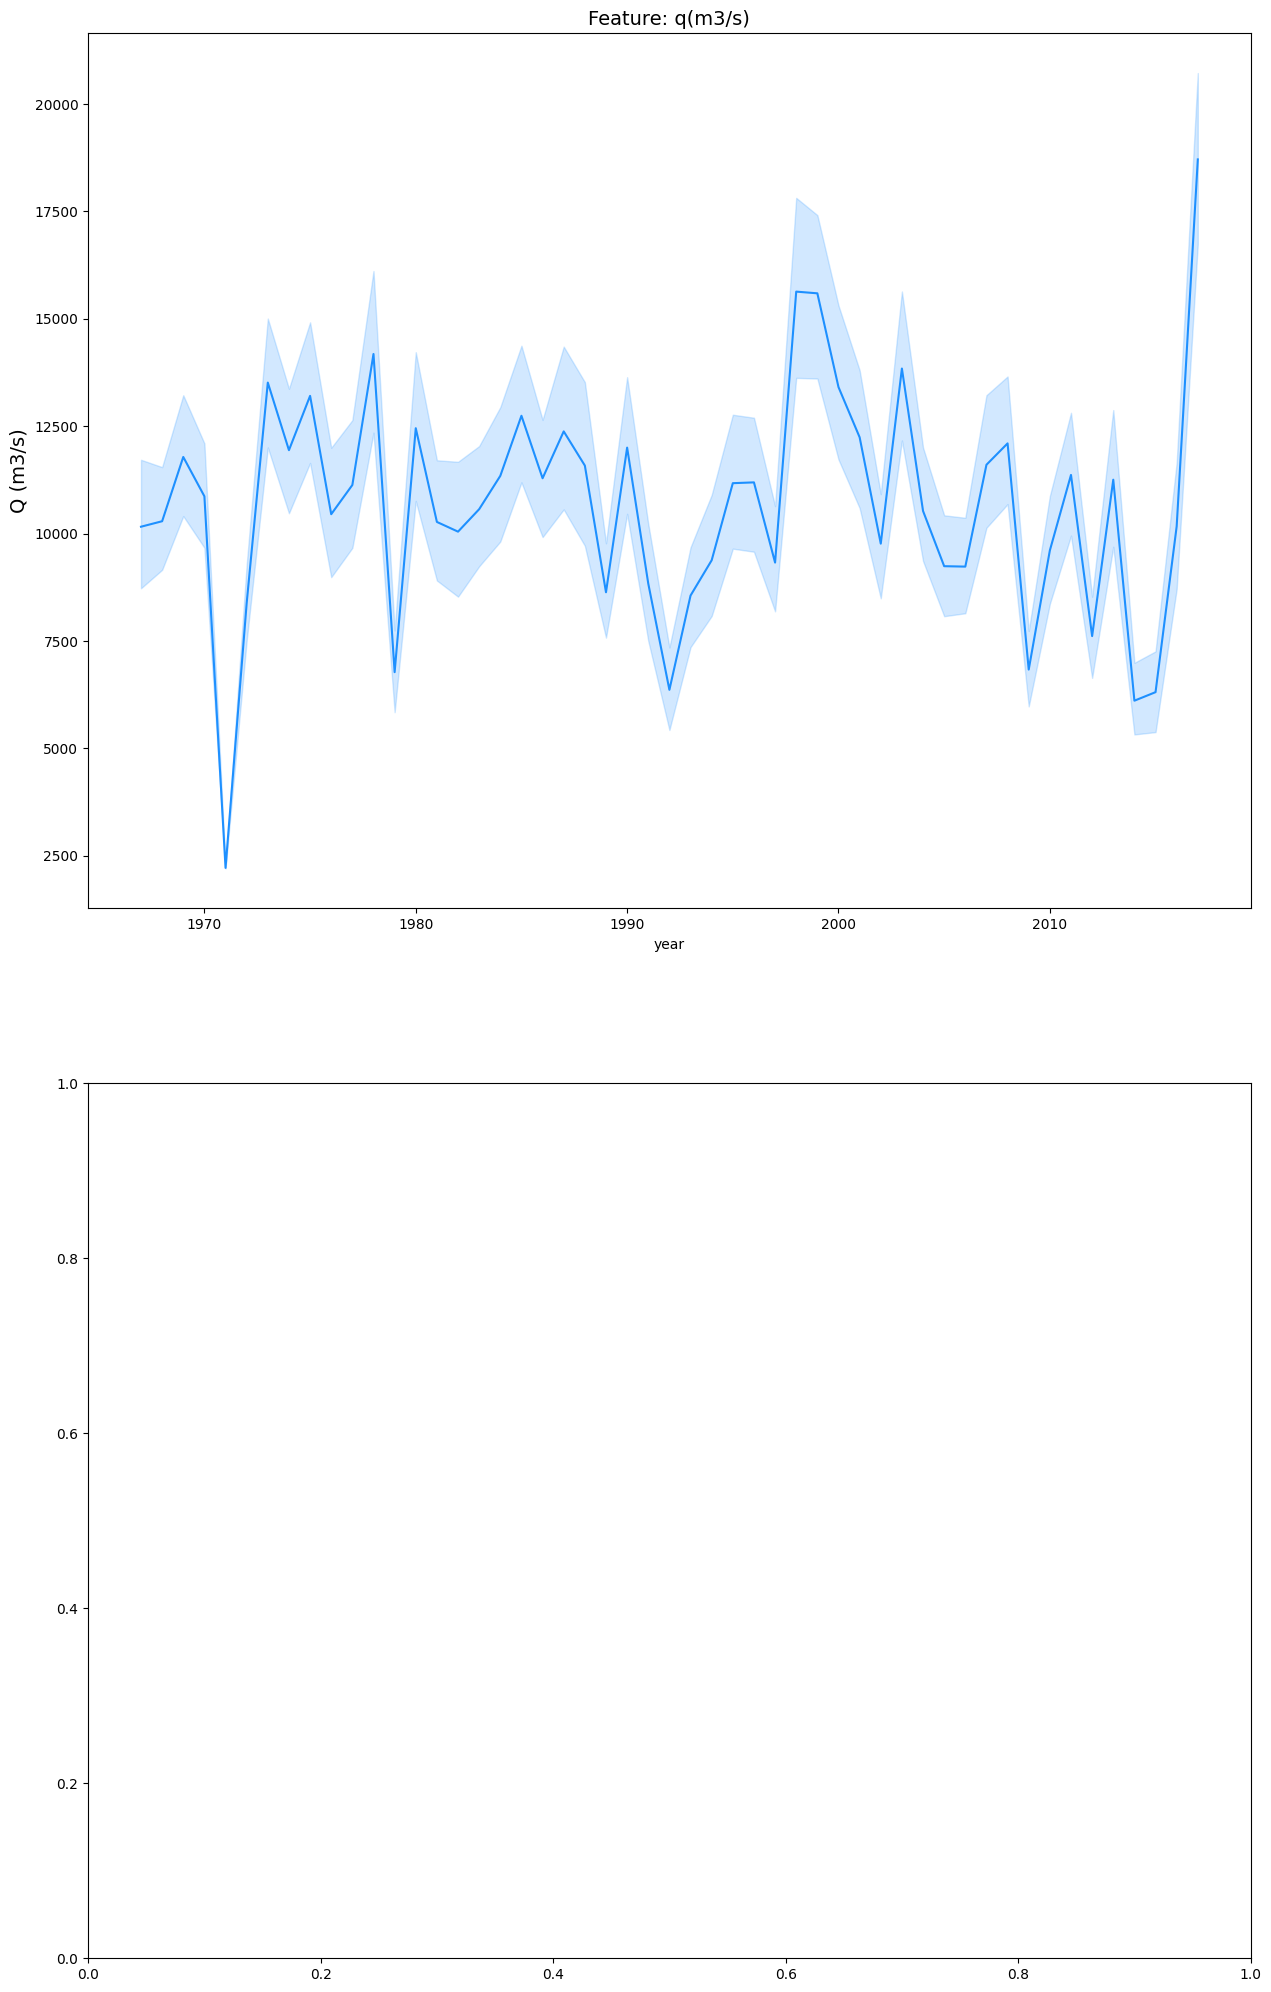

In [ ]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 25))

sns.lineplot(x=df_streamflow['year'], y=df_streamflow['q(m3/s)'].fillna(method='ffill'), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: {}'.format('q(m3/s)'), fontsize=14)
ax[0].set_ylabel(ylabel= 'Q (m3/s)', fontsize=14)

In [ ]:
df_streamflow['date'] = pd.to_datetime(df_streamflow['date'])

#Replace missing values with median value
median_imputer = SimpleImputer(missing_values=np.NaN,strategy='median')

df_streamflow['q(m3/s)'] = median_imputer.fit_transform(df_streamflow[['q(m3/s)']])
display(df_streamflow)

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690.0
1,11964,1967,1,2,1967-01-02,2650.0
2,11965,1967,1,3,1967-01-03,2650.0
3,11966,1967,1,4,1967-01-04,2610.0
4,11967,1967,1,5,1967-01-05,2570.0
...,...,...,...,...,...,...
18623,30586,2017,12,27,2017-12-27,3060.0
18624,30587,2017,12,28,2017-12-28,3060.0
18625,30588,2017,12,29,2017-12-29,3060.0
18626,30589,2017,12,30,2017-12-30,3060.0


In [ ]:
#Convert q(m3/s) datatype to int
df_streamflow['q(m3/s)'] = df_streamflow['q(m3/s)'].astype(int)
display(df_streamflow)

,id,year,month,day,date,q(m3/s)
0,11963,1967,1,1,1967-01-01,2690
1,11964,1967,1,2,1967-01-02,2650
2,11965,1967,1,3,1967-01-03,2650
3,11966,1967,1,4,1967-01-04,2610
4,11967,1967,1,5,1967-01-05,2570
...,...,...,...,...,...,...
18623,30586,2017,12,27,2017-12-27,3060
18624,30587,2017,12,28,2017-12-28,3060
18625,30588,2017,12,29,2017-12-29,3060
18626,30589,2017,12,30,2017-12-30,3060


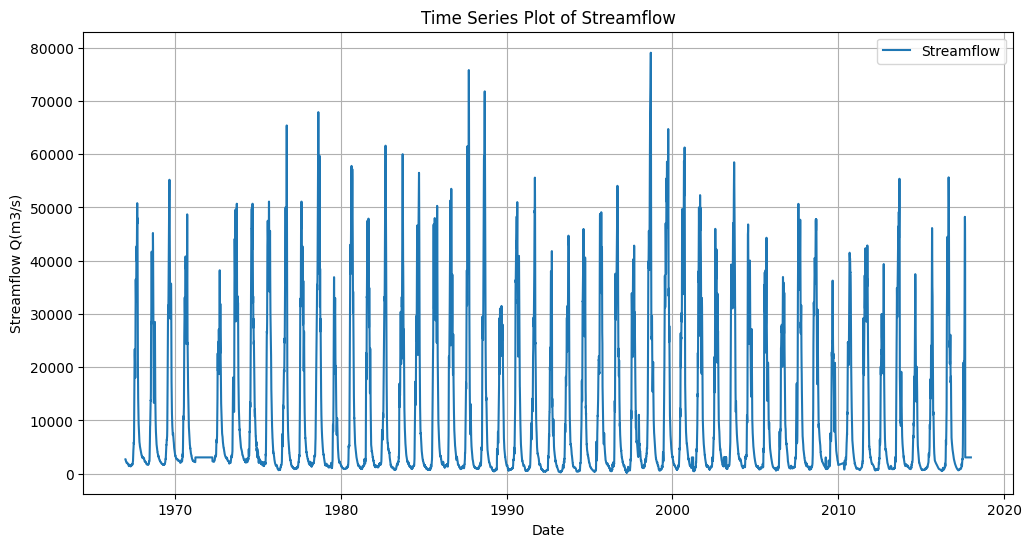

In [ ]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow['date'], df_streamflow['q(m3/s)'], label='Streamflow')
plt.title('Time Series Plot of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Set 'Date' as the index for time series analysis
df_streamflow.set_index('date', inplace=True)

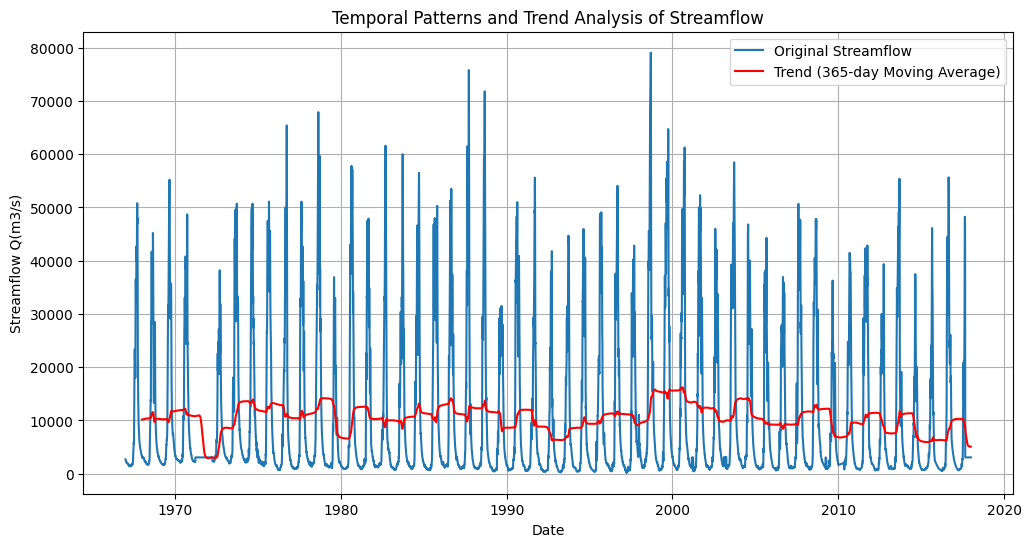

In [ ]:
# Explore overall trend using a rolling mean (moving average)
rolling_mean = df_streamflow['q(m3/s)'].rolling(window=365).mean()  # 365-day moving average for annual trend
trend_df = pd.DataFrame({'Streamflow': df_streamflow['q(m3/s)'], 'Trend': rolling_mean})

# Plot the original streamflow and the trend
plt.figure(figsize=(12, 6))
plt.plot(df_streamflow.index, df_streamflow['q(m3/s)'], label='Original Streamflow')
plt.plot(trend_df.index, trend_df['Trend'], label='Trend (365-day Moving Average)', color='red')
plt.title('Temporal Patterns and Trend Analysis of Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow Q(m3/s)')
plt.legend()
plt.grid(True)
plt.show()

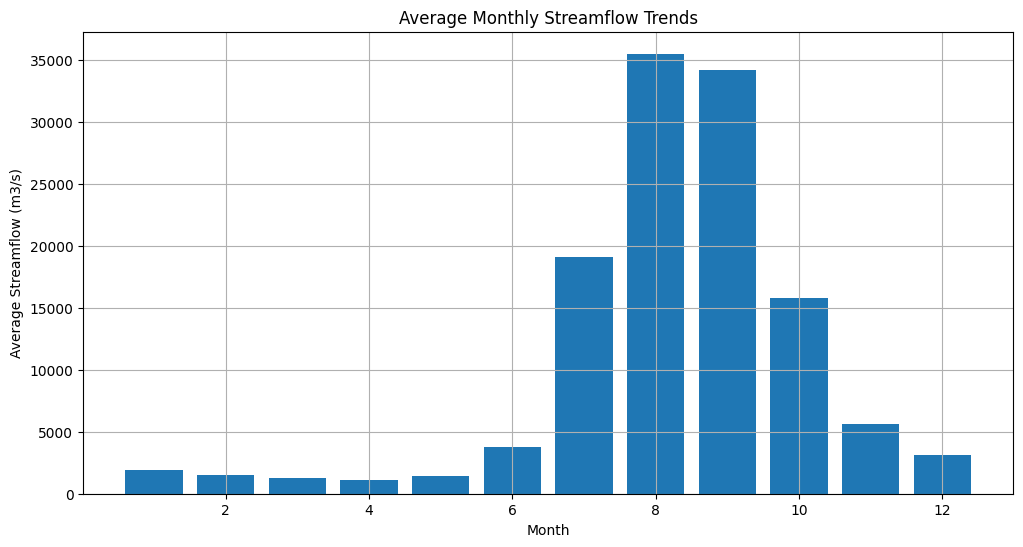

In [ ]:
# Explore trends in different months
monthly_trends = df_streamflow.groupby(df_streamflow.index.month)['q(m3/s)'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_trends.index, monthly_trends.values)
plt.title('Average Monthly Streamflow Trends')
plt.xlabel('Month')
plt.ylabel('Average Streamflow (m3/s)')
plt.grid(True)
plt.show()

In [ ]:
X = df_streamflow.iloc[:, 0:4]
y = df_streamflow.iloc[:, 4:5]

# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# model = LogisticRegression()
# lst_accuracy_scores = []

display(df_streamflow.head())

from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 46)

# for train_index, test_index in kfold.split(X, y):
#     print(train_index)
#     print(test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model.fit(X_train, y_train)
#     score = model.score(X_test, y_test)
#     lst_accuracy_scores.append(score)

# print('List of possible accuracy:', lst_accuracy_scores)
# print('\nMaximum Accuracy that can be obtained from this model is:',max(lst_accuracy_scores)*100, '%')
# print('\nMinimum Accuracy:', min(lst_accuracy_scores)*100, '%')
# print('\nOverall Accuracy:', mean(lst_accuracy_scores)*100, '%')
# print('\nStandard Deviation is:', stdev(lst_accuracy_scores))

,id,year,month,day,q(m3/s)
date,,,,,
1967-01-01,11963,1967,1,1,2690
1967-01-02,11964,1967,1,2,2650
1967-01-03,11965,1967,1,3,2650
1967-01-04,11966,1967,1,4,2610
1967-01-05,11967,1967,1,5,2570


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

models = []

models.append(("KNN Classifier", KNeighborsClassifier(n_neighbors=5)))
models.append(("Decision Tree Classifier", DecisionTreeClassifier()))
models.append(("Random Forest Classifier", RandomForestClassifier(n_estimators=10, random_state=42)))
models.append(("Adaboost Classifier", AdaBoostClassifier(n_estimators=10, random_state=42)))
models.append(("Naive Baiyes Classifier", GaussianNB()))

for name, model in models:
  model.fit(X_train, y_train)
  accuracy = accuracy_score(y_test, model.predict(X_test))
  print("\n", name, "Accuracy:", accuracy * 100.0, '%')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



 KNN Classifier Accuracy: 7.434245840042941 %

 Decision Tree Classifier Accuracy: 9.688674181427805 %


<ipython-input-42-7e6969a728e8>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



 Random Forest Classifier Accuracy: 9.527643585614602 %


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Adaboost Classifier Accuracy: 1.288244766505636 %


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Naive Baiyes Classifier Accuracy: 0.8588298443370908 %


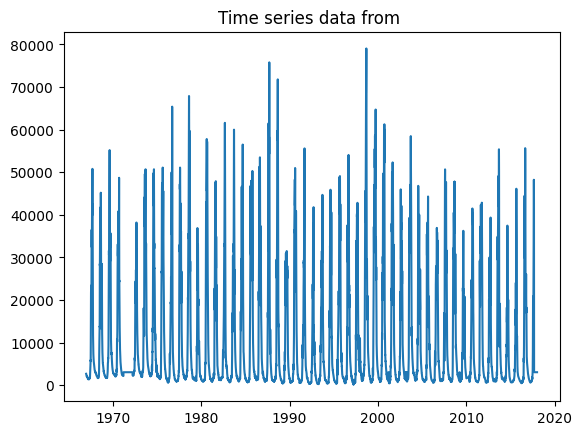

In [ ]:
data = df_streamflow['q(m3/s)']
plt.title("Time series data from 1970 to 2020")
plt.plot(data)

In [ ]:
split_validation = len(data) - 9600
split_test = len(data) - 4800
ts, ts_val, ts_test = (
    data[0:split_validation],
    data[split_validation:split_test],
    data[split_test:],
)
print("Training %d, Validation %d, Test %d" % (len(ts), len(ts_val), len(ts_test)))
print(type(ts))

Training 9028, Validation 4800, Test 4800
<class 'pandas.core.series.Series'>


In [ ]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

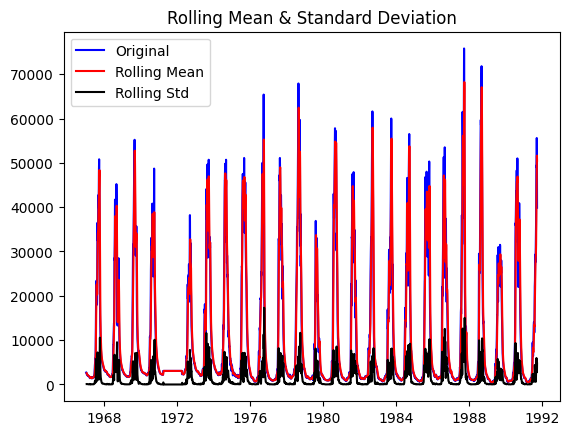

Results of Dickey-Fuller Test:
Test Statistic                -1.054755e+01
p-value                        8.337244e-19
#Lags Used                     3.500000e+01
Number of Observations Used    8.992000e+03
Critical Value (1%)           -3.431077e+00
Critical Value (5%)           -2.861861e+00
Critical Value (10%)          -2.566941e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
#Test stationery of time series data
test_stationarity(ts)

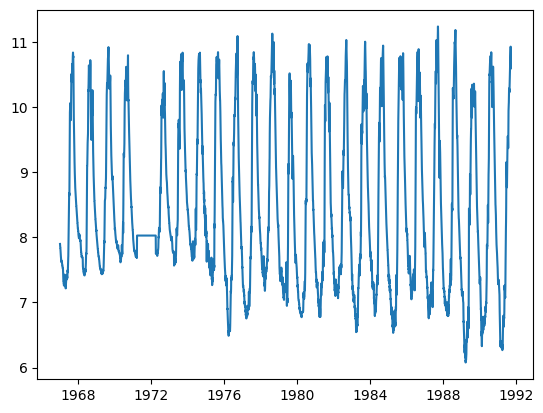

In [ ]:
#Making time series stationary

#Estimating and eliminating trend
ts_log = np.log(ts)
plt.plot(ts_log)

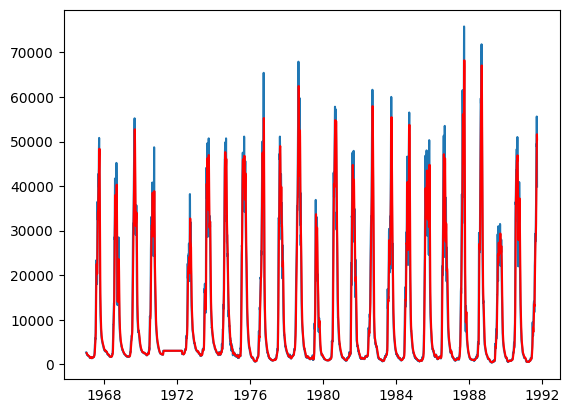

In [ ]:
#Moving Average
moving_avg = ts.rolling(window=12, center=False).mean()
plt.plot(ts)
plt.plot(moving_avg, color="red")

In [ ]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(12)

date
1967-01-01           NaN
1967-01-02           NaN
1967-01-03           NaN
1967-01-04           NaN
1967-01-05           NaN
1967-01-06           NaN
1967-01-07           NaN
1967-01-08           NaN
1967-01-09           NaN
1967-01-10           NaN
1967-01-11           NaN
1967-01-12   -161.666667
Name: q(m3/s), dtype: float64

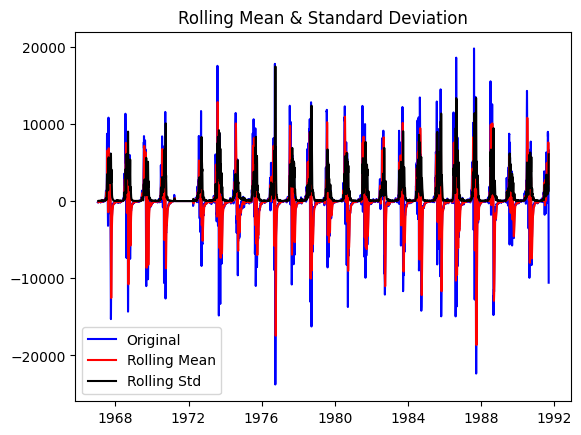

Results of Dickey-Fuller Test:
Test Statistic                -1.281269e+01
p-value                        6.396522e-24
#Lags Used                     3.100000e+01
Number of Observations Used    8.985000e+03
Critical Value (1%)           -3.431078e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566941e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

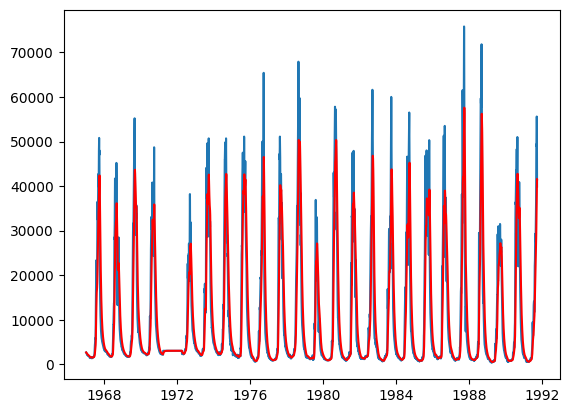

In [ ]:
expwighted_avg = ts.ewm(halflife=12, min_periods=0, adjust=True, ignore_na=False).mean()
plt.plot(ts)
plt.plot(expwighted_avg, color="red")

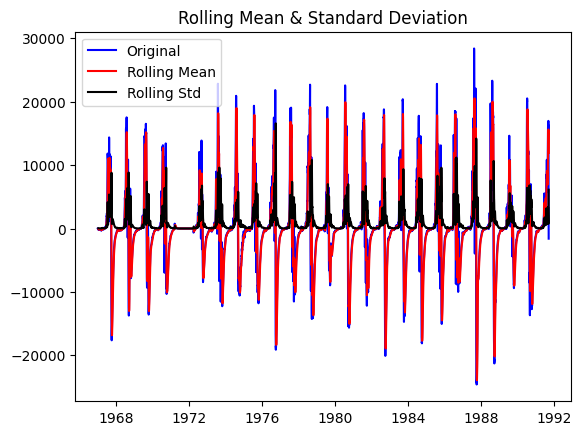

Results of Dickey-Fuller Test:
Test Statistic                -1.220481e+01
p-value                        1.200311e-22
#Lags Used                     3.500000e+01
Number of Observations Used    8.992000e+03
Critical Value (1%)           -3.431077e+00
Critical Value (5%)           -2.861861e+00
Critical Value (10%)          -2.566941e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
ts_ewma_diff = ts - expwighted_avg
test_stationarity(ts_ewma_diff)

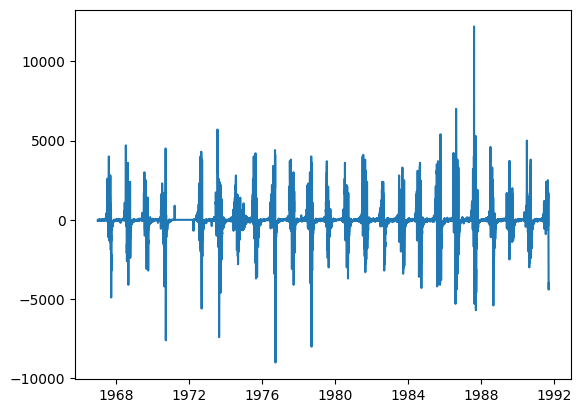

In [ ]:
#Differencing

ts_diff = ts - ts.shift()
plt.plot(ts_diff)

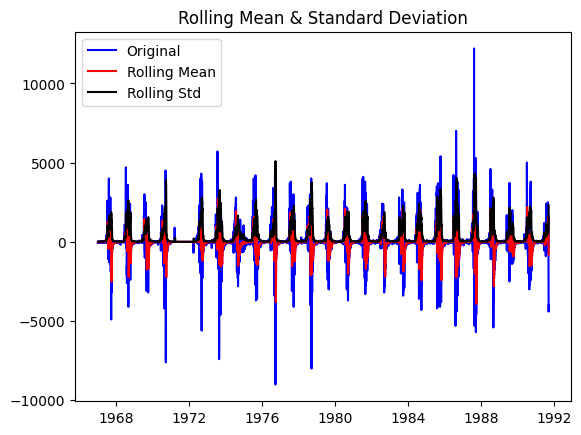

Results of Dickey-Fuller Test:
Test Statistic                -1.412599e+01
p-value                        2.379029e-26
#Lags Used                     2.700000e+01
Number of Observations Used    8.999000e+03
Critical Value (1%)           -3.431077e+00
Critical Value (5%)           -2.861861e+00
Critical Value (10%)          -2.566941e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

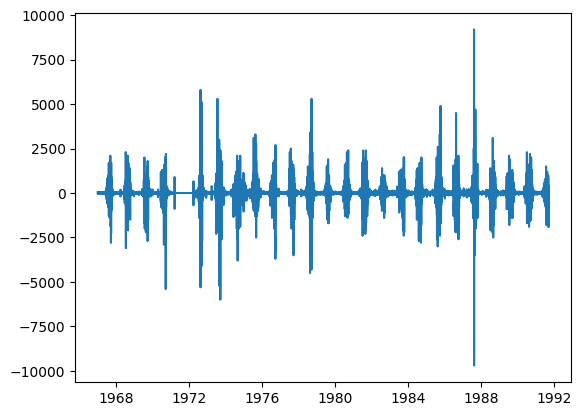

In [ ]:
ts_diff2 = ts - ts.shift() - (ts.shift() - ts.shift(2))
plt.plot(ts_diff2)

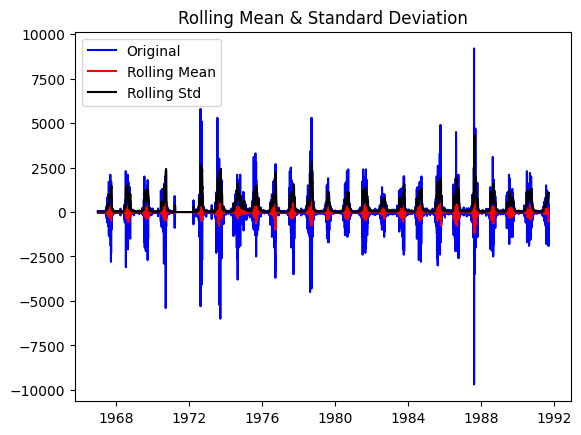

Results of Dickey-Fuller Test:
Test Statistic                  -25.261116
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    8990.000000
Critical Value (1%)              -3.431078
Critical Value (5%)              -2.861862
Critical Value (10%)             -2.566941
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
ts_diff2.dropna(inplace=True)
test_stationarity(ts_diff2)

In [ ]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

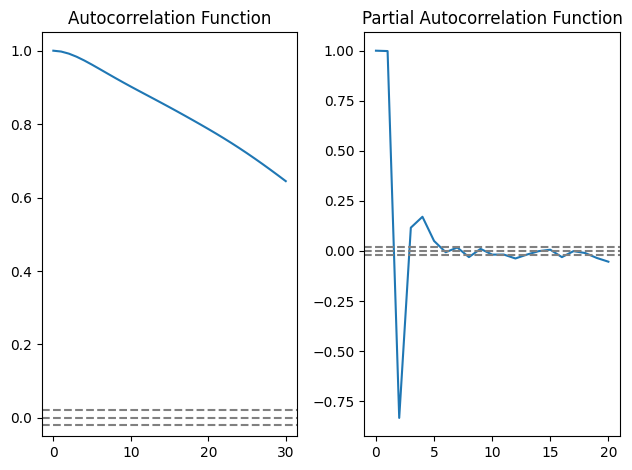

In [ ]:
#Forecasting time series
lag_acf = acf(ts, nlags=30)
lag_pacf = pacf(ts, nlags=20, method="ols")

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


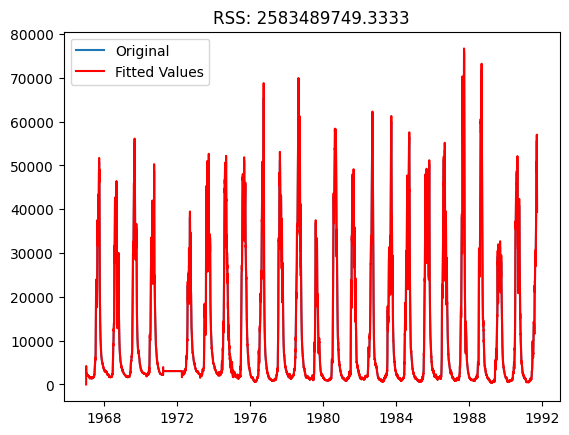

In [ ]:
#AR Model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts, order=(2, 2, 0))
results_AR = model.fit()
plt.plot(ts, label="Original")
plt.plot(results_AR.fittedvalues, color="red", label="Fitted Values")
plt.title("RSS: %.4f" % sum((results_AR.fittedvalues - ts) ** 2))
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 2241447159.2136')

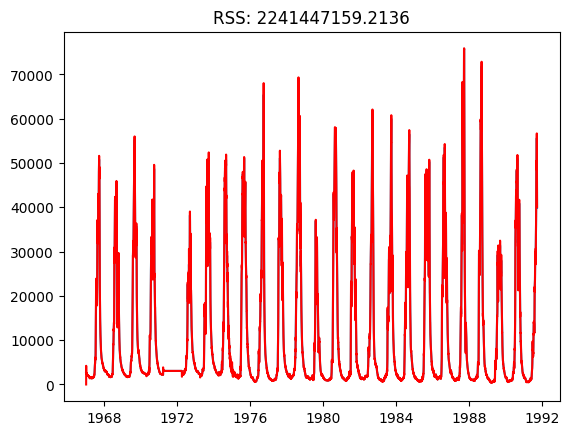

In [ ]:
#MA Model

model = ARIMA(ts, order=(0, 2, 27))
results_MA = model.fit()
plt.plot(ts)
plt.plot(results_MA.fittedvalues, color="red")
plt.title("RSS: %.4f" % sum((results_MA.fittedvalues - ts) ** 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 2239973506.1089')

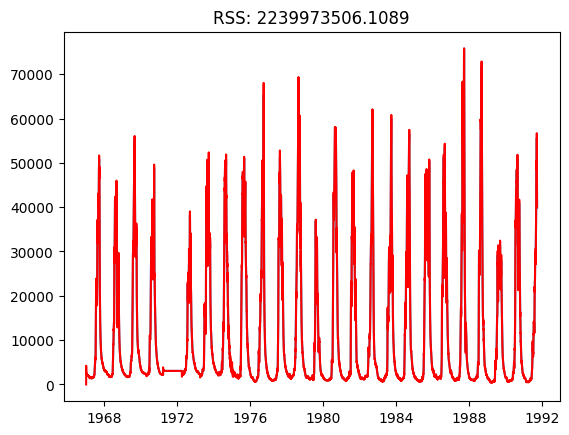

In [ ]:
model = ARIMA(ts, order=(2, 2, 27))
results_ARIMA = model.fit()
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.4f" % sum((results_ARIMA.fittedvalues - ts) ** 2))

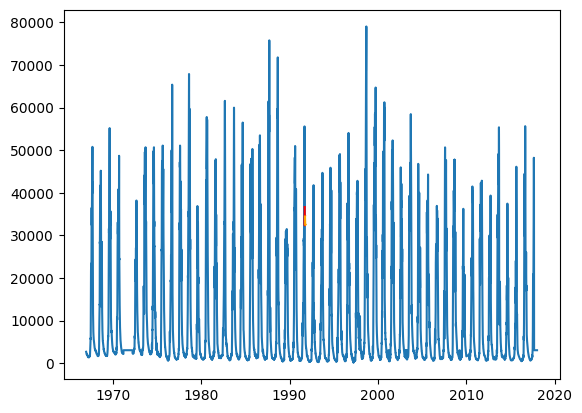

In [ ]:
#Multi-Step Forecasting
yhat_val = results_ARIMA.forecast(steps=12)
yhat_test = results_ARIMA.forecast(steps=36)[-24:]

plt.plot(data)
plt.plot(yhat_val, color="red")
plt.plot(yhat_test, color="orange")

In [1]:
#Recursive Forecasting
# training = ts
# for i in range(split_validation, len(data)):
#     model = ARIMA(training, order=(2, 2, 27))
#     results_ARIMA = model.fit()
#     forecast = results_ARIMA.forecast(steps=1)
#     training = pd.concat([training, forecast])
# plt.plot(data)
# plt.plot(training)